![image](resources/qgss-header.png)

# Lab 9: Hardware-efficient trial states for variational quantum eigensolvers

In this lab, we want to find the ground state energy of the following two-qubit Hamiltonian representing molecular $H_2$ at its equilibrium distance. Note that we have already mapped the fermionic operators onto qubits here.

```
h2_hamiltonian = (-1.0523732)  II + 
                 (0.39793742)  IZ + 
                 (-0.3979374)  ZI + 
                 (-0.0112801)  ZZ + 
                 (0.18093119)  XX
```
                
Note that these co-efficients are functions of the interatomic distance between the atoms. A term like `IZ` is shorthand notation for a tensor product of two-qubit operators -- the identity operator ($I$) on one qubit and pauli-Z operator ($Z$) on the other qubit.

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [ ]:
!pip install -U -r grading_tools/requirements.txt

from IPython.display import clear_output
clear_output()

# Hardware efficient trial states

We need to prepare a guess for the ground state of this Hamiltonian. For this exercise, we will construct a hardware efficient trial state of depth `d=2`, with CNOT (`CX`) gates for the entanglers. We will interleave each entangling layer with a set of $R_yR_z$ gates on each qubit (total 4 layers). For the first guess, we will use rotation angles of $\pi/2$ on all the $R_y$ and $R_z$ gates.

In [1]:
import numpy as np; pi = np.pi
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from copy import deepcopy as make_copy

In [2]:
def prepare_hets_circuit(depth, angle1, angle2):

    hets_circ = QuantumCircuit(depth)
    hets_circ.ry(angle1, 0)
    hets_circ.rz(angle1, 0)
    hets_circ.ry(angle1, 1)
    hets_circ.rz(angle1, 1)

    for ii in range(depth):
        hets_circ.cx(0,1)
        hets_circ.ry(angle2,0)
        hets_circ.rz(angle2,0)
        hets_circ.ry(angle2,1)
        hets_circ.rz(angle2,1)
    
    return hets_circ 

In [3]:
hets_circuit = prepare_hets_circuit(2, pi/2, pi/2)
hets_circuit.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌──────────┐
«q_0: ┤ RZ(pi/2) ├
«     ├──────────┤
«q_1: ┤ RZ(pi/2) ├
«     └──────────┘

# Measuring expectation values

Next, we measure expectation values. **We will begin by measuring the ZZ expectation value, or $\langle ZZ \rangle$**. We will first create a copy of the `hets_circ` quantum circuit that we created above, and add measurements to it.

In [4]:
def measure_zz_circuit(given_circuit):
    zz_meas = make_copy(given_circuit)
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(hets_circuit)
zz_meas.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
   q_0: ┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├»
        ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
   q_1: ┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├»
        └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
meas_0: ══════════════════════════════════════════════════════════════════════»
                                                                              »
meas_1: ══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌──────────┐ ░ ┌─┐   
«   q_0: ┤ RZ(pi/2) ├─░─┤M├───
«        ├──────────┤ ░ └╥┘┌─┐
«   q_1: ┤ RZ(pi/2) ├─░──╫─┤M├
«        └──────────┘ ░  ║ └╥┘
«meas_0: ════════════════╩══╬═
«                           ║ 
«meas_1: ═══════════════════╩═
«

Next, let's execute this quantum circuit and see the measurement outcomes.

In [5]:
simulator = Aer.get_backend('qasm_simulator')

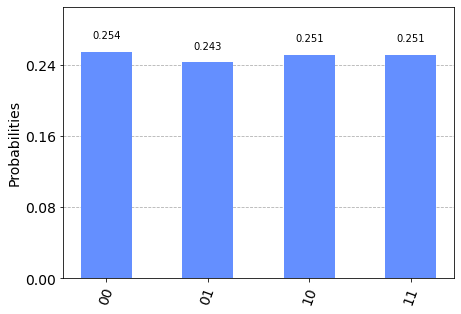

In [6]:
result = execute(zz_meas, backend = simulator, shots=10000).result()
counts = result.get_counts(zz_meas)

plot_histogram(counts)

We can analyze the counts and calculate the $\langle ZZ \rangle$ as follows:

In [7]:
def measure_zz(given_circuit, num_shots = 10000):

    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zz = zz / total_counts
    
    return zz

In [8]:
zz = measure_zz(hets_circuit)
print("<ZZ> =", str(zz))

<ZZ> = 0.0008


**What about $\langle ZI \rangle$ and  $\langle IZ \rangle$? Do these need new circuits?**

The answer is no, and they can be computed from the results above.

In [9]:
def measure_zi(given_circuit, num_shots = 10000):
    
    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    
    zi = counts['00'] - counts['11'] + counts['01'] - counts['10']
    zi = zi / total_counts
    
    return zi

def measure_iz(given_circuit, num_shots = 10000):
    
    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    
    iz = counts['00'] - counts['11'] - counts['01'] + counts['10']
    iz = iz / total_counts
    
    return iz

In [10]:
zi = measure_zi(hets_circuit)
print("<ZI> =", str(zi))

iz = measure_iz(hets_circuit)
print("<IZ> =", str(iz))

<ZI> = -0.002
<IZ> = 0.0162


**Next, we measure $\langle XX \rangle$**

In [11]:
def measure_xx_circuit(given_circuit):
    xx_meas = make_copy(given_circuit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    xx_meas.h(0)
    xx_meas.h(1)
    xx_meas.measure_all()
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

    return xx_meas

In [12]:
xx_meas = measure_xx_circuit(hets_circuit)
xx_meas.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
   q_0: ┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├┤ RZ(pi/2) ├──■──┤ RY(pi/2) ├»
        ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
   q_1: ┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├┤ RZ(pi/2) ├┤ X ├┤ RY(pi/2) ├»
        └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
meas_0: ══════════════════════════════════════════════════════════════════════»
                                                                              »
meas_1: ══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌──────────┐┌───┐ ░ ┌─┐   
«   q_0: ┤ RZ(pi/2) ├┤ H ├─░─┤M├───
«        ├──────────┤├───┤ ░ └╥┘┌─┐
«   q_1: ┤ RZ(pi/2) ├┤ H ├─░──╫─┤M├
«        └──────────┘└───┘ ░  ║ └╥┘
«meas_0: ═════════════════════╩══╬═
«                                ║ 
«meas_1: ════════════════════════╩═
«

In [13]:
def measure_xx(given_circuit, num_shots = 10000):
    
    xx_meas = measure_xx_circuit(given_circuit)
    
    result = execute(xx_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(xx_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    xx = counts['00'] + counts['11'] - counts['01'] - counts['10']
    xx = xx / total_counts
    
    return xx

xx = measure_xx(hets_circuit)
print("<XX> =", str(xx))

<XX> = -1.0


### Now we evaluate the energy of the trial state

In [14]:
def get_energy(given_circuit, num_shots = 10000):
    
    zz = measure_zz(given_circuit, num_shots = num_shots)
    iz = measure_iz(given_circuit, num_shots = num_shots)
    zi = measure_zi(given_circuit, num_shots = num_shots)
    xx = measure_xx(given_circuit, num_shots = num_shots)
    
    energy = (-1.0523732)*1 + (0.39793742)*iz + (-0.3979374)*zi + (-0.0112801)*zz + (0.18093119)*xx
    
    return energy

In [15]:
energy = get_energy(hets_circuit)
print("The energy of the trial state is", str(energy))

The energy of the trial state is -1.2417197319559998


# Computing gradients

The objective of the next set of exercises is to compute the next set of angles to use for the trial state preparation. Create two quantum circuits using `prepare_hets_circuit(depth=2, angle2 = pi/2)` for measuring expectation values with values for `angle1 = pi/2 + 0.1*pi/2` and `angle1 = pi/2 - 0.1*pi/2`, and measure the energy of both trial states.

In [16]:
hets_circuit_plus = None
hets_circuit_minus = None

### WRITE YOUR CODE BETWEEN THESE LINES - START

hets_circuit_plus = prepare_hets_circuit(2, pi/2 + 0.1*pi/2, pi/2)
hets_circuit_minus = prepare_hets_circuit(2, pi/2 - 0.1*pi/2, pi/2)

### WRITE YOUR CODE BETWEEN THESE LINES - END

energy_plus = get_energy(hets_circuit_plus, num_shots=100000)
energy_minus = get_energy(hets_circuit_minus, num_shots=100000)

print(energy_plus, energy_minus)

-1.1607756433903997 -1.2751110680222


As you can see, one of these is certainly lower energy than the other, and is also lower energy than the case when `angle1 = pi/2`. This is a suitable next point for our iteration of a variational eigensolver.

# Submitting your solutions for grading

Now, grade your solution by running the cell below after filling in your name and email address. Always provide the same name and email as the one you used during registration to ensure consistency.

In [17]:
name = 'Pon Rahul M'
email = 'ponrahul.21it@licet.ac.in'

### Do not change the lines below
from grading_tools import grade

grade(answer=measure_xx_circuit(hets_circuit), name=name, email=email, labid='lab9', exerciseid='ex1')
grade(answer=hets_circuit_plus, name=name, email=email, labid='lab9', exerciseid='ex2')
grade(answer=hets_circuit_minus, name=name, email=email, labid='lab9', exerciseid='ex3')

Grading...
lab9/ex1 - 🎉 Correct
🎊 Hurray! You have a new correct answer! Let's submit it.
Submitting the answers for lab9...
📝 Our records, so far, are:
Correct answers: lab1:ex1, lab2:ex1, lab3:ex1, lab4:ex1, lab5:ex1, lab6:ex1a, lab6:ex1b, lab9:ex1
Grading...
lab9/ex2 - 🎉 Correct
🎊 Hurray! You have a new correct answer! Let's submit it.
Submitting the answers for lab9...
📝 Our records, so far, are:
Correct answers: lab1:ex1, lab2:ex1, lab3:ex1, lab4:ex1, lab5:ex1, lab6:ex1a, lab6:ex1b, lab9:ex1, lab9:ex2
Grading...
lab9/ex3 - 🎉 Correct
🎊 Hurray! You have a new correct answer! Let's submit it.
Submitting the answers for lab9...
📝 Our records, so far, are:
Correct answers: lab1:ex1, lab2:ex1, lab3:ex1, lab4:ex1, lab5:ex1, lab6:ex1a, lab6:ex1b, lab9:ex1, lab9:ex2, lab9:ex3


## Bonus 1

While this is not graded, explore whether the decision above would be easy if your execution ran different numbers of shots. In particular, measure `energy_plus` and `energy_minus` again with `100`, `1000` and `10000` shots to explore how easy or difficult this decision gets with each one.

In [18]:
energy_plus_100, energy_plus_1000, energy_plus_10000 = 0, 0, 0
energy_minus_100, energy_minus_1000, energy_minus_10000 = 0, 0, 0

### WRITE YOUR CODE BETWEEN THESE LINES - START

energy_plus_100 = get_energy(hets_circuit_plus, num_shots = 100)
energy_minus_100 = get_energy(hets_circuit_minus, num_shots = 100)

energy_plus_1000 = get_energy(hets_circuit_plus, num_shots = 1000)
energy_minus_1000 = get_energy(hets_circuit_minus, num_shots = 1000)

energy_plus_10000 = get_energy(hets_circuit_plus, num_shots = 10000)
energy_minus_10000 = get_energy(hets_circuit_minus, num_shots = 10000)

### WRITE YOUR CODE BETWEEN THESE LINES - END

print(energy_plus_100, energy_minus_100, "difference = ", energy_minus_100 - energy_plus_100)
print(energy_plus_1000, energy_minus_1000, "difference = ", energy_minus_1000 - energy_plus_1000)
print(energy_plus_10000, energy_minus_10000, "difference = ", energy_minus_10000 - energy_plus_10000)

-1.2198685179999997 -1.3695502115999998 difference =  -0.14968169360000005
-1.1590297934799998 -1.2805612395 difference =  -0.1215314460200001
-1.1535626450299998 -1.2906174813959999 difference =  -0.13705483636600002


## Bonus 2

While this is not graded, diagonalize the Hamiltonian by writing down the matrices for the Pauli operators `I`, `X` and `Z`, and find the exact ground state energy.

In [19]:
### WRITE YOUR CODE BETWEEN THESE LINES - START

I = np.array([
[1, 0],
[0, 1]
])

X = np.array([
[0, 1],
[1, 0]
])

Z = np.array([
[1, 0],
[0, -1]
])

h2_hamiltonian = (-1.0523732) * np.kron(I, I) + \
                 (0.39793742) * np.kron(I, Z) + \
                 (-0.3979374) * np.kron(Z, I) + \
                 (-0.0112801) * np.kron(Z, Z) + \
                 (0.18093119) * np.kron(X, X)

from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eig(h2_hamiltonian)
for ii, eigenvalue in enumerate(eigenvalues):
    print(f"Eigenvector {eigenvectors[:,ii]} has energy {eigenvalue}")

exact_eigenvector = eigenvectors[:,np.argmin(eigenvalues)]
exact_eigenvalue = np.min(eigenvalues)

print()
print("Minimum energy is", exact_eigenvalue)

### WRITE YOUR CODE BETWEEN THESE LINES - END

Eigenvector [0.70710682 0.         0.         0.70710674] has energy -0.8827221099999987
Eigenvector [ 0.70710674  0.          0.         -0.70710682] has energy -1.2445844900000007
Eigenvector [-2.07048005e-16 -9.93760401e-01  1.11535937e-01  8.23943737e-16] has energy -1.857274957569039
Eigenvector [5.61877442e-18 1.11535937e-01 9.93760401e-01 3.55011052e-17] has energy -0.22491124243096008

Minimum energy is -1.857274957569039
